# 1. Descrição do Dataset

Dataset publicado em 18 de junho de 2021 no site [Zenodo](https://zenodo.org/record/4946917) por Yasuhiro Suzuki.

Essa base foi formada por 226 respondentes que foram admitidos no Hospital da Universidade de Tsukuba para tratamento de diabetes tipo 2.

O questionário foi aplicado após **1 ano** de entrada no hospital, portanto as quedas registradas no campo **Year Fall** aconteceram no período de um ano. Enquanto os outros dados dos pacientes, são referentes ao momento de entrada no hospital.

**Não possui campos categóricos com campo em texto, está pronta para normalização**

#### Funções Úteis

In [ ]:
def print_results(opt, X_train, X_test, Y_train, Y_test):
  opt.fit(X_train, Y_train)

  print("Combinação de Hiperparâmetros ótima", opt.best_params_)
  print()
  print("Pontuação média de precisão de treinamento com validação cruzada:",
        opt.best_score_)

  opt.best_estimator_.fit(x_train, y_train)
  y_pred = opt.best_estimator_.predict(x_test) # Predições
  y_pred_proba = opt.best_estimator_.predict_proba(x_test)[::,1] # Predições
  y_true = y_test #Valores Verdadeiros

  # Cálculo de Acurácia
  print("Acurácia de Teste:", np.round(accuracy_score(y_true, y_pred), 2))
  cf_matrix = confusion_matrix(y_true, y_pred)

  # Matriz de Confusão
  sns.heatmap(cf_matrix, annot=True, cmap='Blues')
  plt.xlabel('Preditos')
  plt.ylabel('Verdadeiros')

  # Plot da curva ROC
  auc = roc_auc_score(y_true, y_pred_proba)

  false_positive_rate, true_positive_rate, threshold = roc_curve(y_true, y_pred_proba)

  print('roc_auc_score:  ', roc_auc_score(y_true, y_pred_proba))

  plot_auc(false_positive_rate, true_positive_rate)

In [ ]:
def get_metrics(opt, X_train, X_test, Y_train, Y_test):
  

In [ ]:
def plot_auc(fpr, tpr):
  plt.subplots(1, figsize=(10,10))
  plt.title('ROC')
  plt.plot(fpr, tpr)
  plt.plot([0, 1], ls="--")
  plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
  plt.ylabel('Taxa de Verdadeiros Positivos')
  plt.xlabel('Taxa de Falsos Positivos')
  plt.show()

# 2. Pré-processamento e Bibliotecas utilizadas



### 2.1 Imports Necessários

Aqui serão importadas, tanto as classes auxiliares quanto as bibliotecas padrão para análise e pré-processamento de dados.

In [ ]:
# Pré-Processamento
from scaler import df_scaler
from imputer import df_imputer
from feature_selector import feature_selector
from dummifier import df_dummify
from cat_transform import make_ordinal
from feature_union import df_FeatureUnion


from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt 
import time
import numpy as np 

import pandas as pd

### 2.2 Leitura da Base

In [ ]:
data_diabetes_full = pd.read_excel('Bases/Base_diabetes_formatada.xlsx')
print("Números de linhas e colunas da base original - orig", data_diabetes_full.shape)

Números de linhas e colunas da base original - orig (226, 64)


### 2.3 Remoção de Características

Remoção inicial de características com 100% dos campos vazios ou IDS, como IDs de hospital ou de pacientes. Informações que de cara já não impactarão no treinamento do modelo.

In [ ]:
data_diabetes = data_diabetes_full.drop(columns="ID1")

### 2.4 Transformação das features categóricas em tipo categórico

In [ ]:
feat_cat = ["Diabetic polyneuropathy","Impaired vibratory sensation","Cardiac autonomic neuropathy","Nephropathy","Retinopathy","Coronary artery disease","Stroke", "Peripheral arterial disease",
           "Sulfonylureas","Glinides","Biguanides","SGLT2 inhibitors","α-glucosidase inhibitors","Thiazolidinedione","DPP-4 inhibitors","GLP-1 receptor agonists","Insulin",
            "Antihyperlipidemic agents", "Antihypertensive agents", "Sex"]

data_diabetes[feat_cat] = data_diabetes[feat_cat].astype("object")

### 2.5 Pipeline para valores numéricos

* Seleção das variáveis numéricas
* Tratamento de valores vazios com média ou mediana

In [ ]:
numeric_pipeline = Pipeline([('fs', feature_selector(dtype="numeric")), ('imputer', df_imputer(strategy = "mean"))])

### 2.6 Pipeline para valores categóricos

* Seleção das variáveis categóricas
* Tratamento de valores vazios com o valor mais frequente da coluna

In [ ]:
categoric_pipeline = Pipeline([('fs', feature_selector(dtype="category")), ('imputer', df_imputer(strategy = "most_frequent"))])

### 2.7 Pipeline de Processamento

In [ ]:
processing_pipe = df_FeatureUnion(transformer_list=[('cat_pipe', categoric_pipeline), ('num_pipe', numeric_pipeline)])

### 2.8 Separação de X e Y

In [ ]:
Y = data_diabetes["Year Fall"]
X = data_diabetes.drop(columns="Year Fall")

# x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2)

# 3. Treinamentos

### 3.1 Pipeline para SVM, XGBoost e MLP

In [ ]:
pipe_svm = Pipeline(steps=[('processing', processing_pipe), 
                      ('scaler', df_scaler()),
                      ('clf', SVC(probability = True))])

pipe_xgboost = Pipeline([('processing', processing_pipe), 
                      ('scaler', df_scaler()),
                      ('clf', xgb.XGBClassifier())])

pipe_MLP = Pipeline([('processing', processing_pipe), 
                      ('scaler', df_scaler()),
                      ('clf', MLPClassifier())])

### 3.2 Testes iniciais, sem tuning.


#### SVM

In [ ]:
sum_acc = 0
sum_auc = 0

iter = 100

for i in range (iter):
  x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2)

  model = pipe_svm.fit(x_train, y_train)

  prediction = model.predict(x_test)
  prediction_proba = model.predict_proba(x_test)[::,1]

  acc = round(accuracy_score(y_test, prediction)*100,2)
  sum_acc = sum_acc + acc

  auc_score = roc_auc_score(y_test, prediction_proba)

  sum_auc = sum_auc + auc_score

  # plot_auc(false_positive_rate, true_positive_rate)

res_acc = sum_acc/100
res_auc = sum_auc/100
res_f1_score = f1_score_sum/100

print(res_acc)
print(res_auc)

#### XGBoost

In [ ]:
sum_acc_XG = 0
sum_auc_XG = 0

for i in range (100):
  x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2)

  model = pipe_xgboost.fit(x_train, y_train)

  prediction = model.predict(x_test)
  prediction_proba = model.predict_proba(x_test)[::,1]

  sum_acc_XG = sum_acc_XG + round(accuracy_score(y_test, prediction)*100,2)

  auc_score = roc_auc_score(y_test, prediction_proba)

  sum_auc_XG = sum_auc_XG + auc_score

res_acc_XG = sum_acc_XG/100
res_auc_XG = sum_auc_XG/100

print(res_acc_XG)
print(res_auc_XG)

#### MLP

In [ ]:
sum_acc_MLP = 0
sum_auc_MLP = 0

for i in range (100):
  x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2)

  model = pipe_MLP.fit(x_train, y_train)

  prediction = model.predict(x_test)
  prediction_proba = model.predict_proba(x_test)[::,1]

  sum_acc_MLP= sum_acc_XG + round(accuracy_score(y_test, prediction)*100,2)

  auc_score = roc_auc_score(y_test, prediction_proba)

  sum_auc_MLP = sum_auc_XG + auc_score

sum_acc_MLP = sum_acc_MLP/100
sum_auc_MLP = sum_auc_MLP/100

print(sum_acc_MLP)
print(sum_auc_MLP)

#### 3.3 Utilização do Random Search e Grid Search

#### 3.3.1 Grid Search - SVM

In [ ]:
start = time.time()

hyperparam_space_SVM = {'clf__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000], 'clf__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'clf__kernel': ['rbf', 'poly', 'sigmoid']}

gs_SVM = GridSearchCV(pipe_svm, param_grid=hyperparam_space_SVM, 
                  scoring="roc_auc",
                  n_jobs=-1, cv=10, return_train_score=True)

print_results(gs_SVM, x_train, x_test, y_train, y_test)

#Tempo de execução
end = time.time()
diff = end - start
print('Tempo de Execução do Grid Search (em segundos):', diff)
print()

#### 3.3.2 Random Search - SVM

Combinação de Hiperparâmetros ótima {'clf__kernel': 'sigmoid', 'clf__gamma': 0.011, 'clf__C': 27.300000000000004}

Pontuação média de precisão de treinamento com validação cruzada: 0.6652777777777777
Acurácia de Teste: 0.72
roc_auc_score:   0.551219512195122


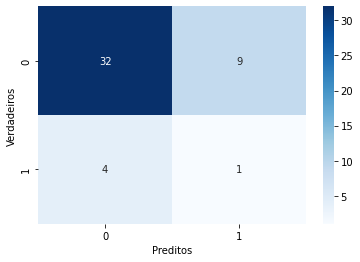

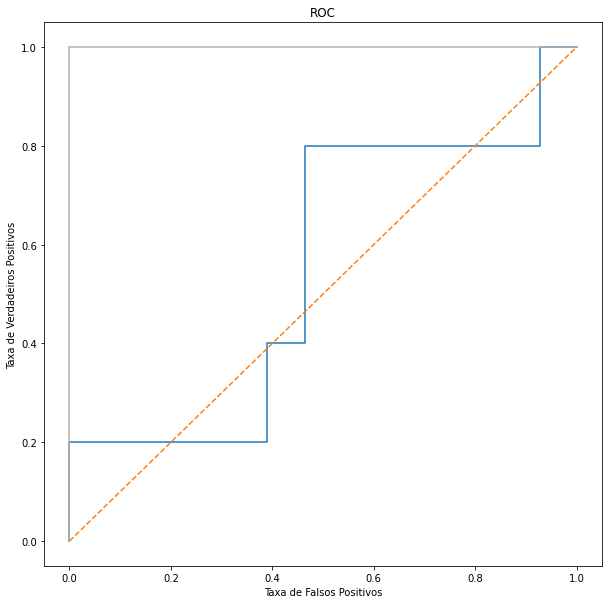

Tempo de Execução do Random Search (em segundos): 519.7178437709808



In [ ]:
start = time.time()

x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2)

hyperparam_space_SVM = {'clf__C': np.arange(0.1, 100, 0.1), 'clf__gamma': np.arange(0.001, 10, 0.01), 'clf__kernel': ['rbf', 'poly', 'sigmoid']}

rs_SVM = RandomizedSearchCV(pipe_svm, param_distributions=hyperparam_space_SVM,
                        n_iter=1000, scoring="roc_auc",
                        n_jobs=-1, cv=10, return_train_score=True)

print_results(rs_SVM, x_train, x_test, y_train, y_test)

#Tempo de execução
end = time.time()
diff = end - start
print('Tempo de Execução do Random Search (em segundos):', diff)
print()

#### Validação do Melhor Parâmetro - SVM

In [ ]:
pipe_svm = Pipeline(steps=[('processing', processing_pipe), 
                      ('scaler', df_scaler()),
                      ('clf', SVC(probability = True, kernel = "sigmoid", C = 27.3, gamma = 0.011))])

sum_acc = 0
sum_auc = 0

iter = 100

for i in range (iter):
  x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2)

  model = pipe_svm.fit(x_train, y_train)

  prediction = model.predict(x_test)
  prediction_proba = model.predict_proba(x_test)[::,1]

  acc = round(accuracy_score(y_test, prediction)*100,2)
  sum_acc = sum_acc + acc

  auc_score = roc_auc_score(y_test, prediction_proba)

  sum_auc = sum_auc + auc_score

  # plot_auc(false_positive_rate, true_positive_rate)

res_acc = sum_acc/100
res_auc = sum_auc/100
res_f1_score = f1_score_sum/100

print(res_acc)
print(res_auc)

NameError: ignored

#### 3.3.2 Random Search - MLP


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Combinação de Hiperparâmetros ótima {'clf__solver': 'adam', 'clf__learning_rate': 'constant', 'clf__hidden_layer_sizes': (100,), 'clf__alpha': 0.05, 'clf__activation': 'relu'}

Pontuação média de precisão de treinamento com validação cruzada: 0.5821428571428572


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Acurácia de Teste: 0.8
roc_auc_score:   0.5892857142857143


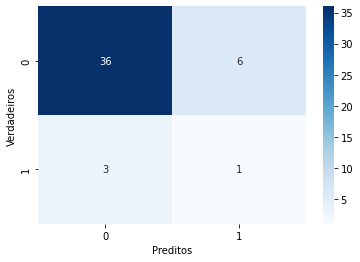

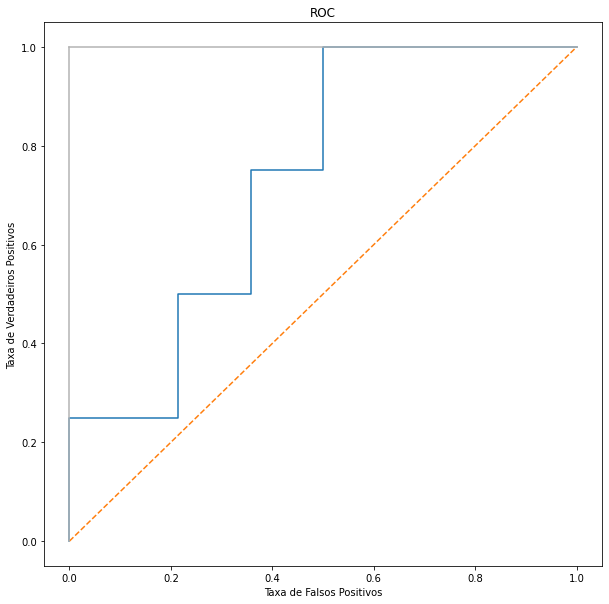

Tempo de Execução do Random Search (em segundos): 30.958291053771973



In [ ]:
start = time.time()

hyperparam_space_MLP= {
                      'clf__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
                      'clf__activation': ['tanh', 'relu'],
                      'clf__solver': ['sgd', 'adam'],
                      'clf__alpha': [0.0001, 0.05],
                      'clf__learning_rate': ['constant','adaptive'],
                  }

rs_MLP = RandomizedSearchCV(pipe_MLP, param_distributions=hyperparam_space_MLP,
                        n_iter=10, scoring="roc_auc",
                        n_jobs=-1, cv=10, return_train_score=True)

print_results(rs_MLP, x_train, x_test, y_train, y_test)

#Tempo de execução
end = time.time()
diff = end - start
print('Tempo de Execução do Random Search (em segundos):', diff)
print()

#### 3.3.3 Random Search - XGBoost

Combinação de Hiperparâmetros ótima {'clf__subsample': 0.8999999999999999, 'clf__n_estimators': 100, 'clf__max_depth': 3, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.6, 'clf__colsample_bylevel': 0.8999999999999999}

Pontuação média de precisão de treinamento com validação cruzada: 0.6285714285714286
Acurácia de Teste: 0.85
roc_auc_score:   0.5892857142857143


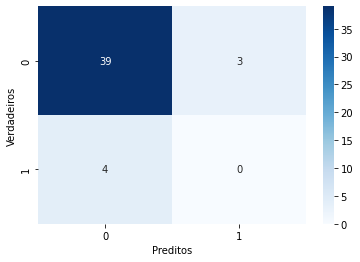

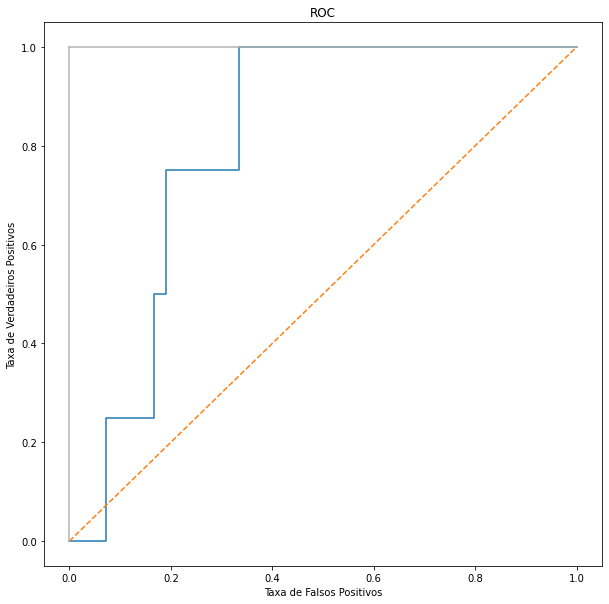

Tempo de Execução do Random Search (em segundos): 87.85091090202332



In [ ]:
start = time.time()

hyperparam_space_XGBoost = {'clf__max_depth': [3, 5, 6, 10, 15, 20],
           'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
           'clf__subsample': np.arange(0.5, 1.0, 0.1),
           'clf__colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'clf__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'clf__n_estimators': [100, 500, 1000]
        }

rs_XGBoost = RandomizedSearchCV(pipe_xgboost, param_distributions=hyperparam_space_XGBoost,
                        n_iter=50, scoring="roc_auc",
                        n_jobs=-1, cv=10, return_train_score=True)

print_results(rs_XGBoost, x_train, x_test, y_train, y_test)

#Tempo de execução
end = time.time()
diff = end - start
print('Tempo de Execução do Random Search (em segundos):', diff)
print()